# Stratified Sampling Implementation

This notebook implements and demonstrates the starfight sampling algorithm, which is a technique for selecting representative data points from a larger dataset.

## Import Required Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from scipy.spatial import distance
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

np.random.seed(42)

# Stratified Sampling for Clustering Performance

Stratified sampling ensures that the reduced dataset preserves the same distribution of key characteristics as the original data, which is essential for accurate clustering.

In [4]:
def create_stratified_sample(df, strata_cols, sample_size=10000, random_state=42):
    """
    Create a stratified sample of the data based on multiple categorical columns.
    Handles cases with too many strata by using a simpler stratification approach.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The original dataframe to sample from
    strata_cols : list
        List of column names to use for stratification
    sample_size : int
        Desired size of the sample
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    pandas DataFrame
        A stratified sample of the original data
    """
    # Choose the most important strata columns if we have too many
    if len(strata_cols) > 2 and sample_size < 20000:
        # Check if 'city' is in the strata columns (likely the most important)
        if 'city' in strata_cols:
            # Use city and one temporal feature (like hour or dayofweek)
            if 'hour' in strata_cols:
                simplified_strata = ['city', 'hour']
            elif 'dayofweek' in strata_cols:
                simplified_strata = ['city', 'dayofweek']
            else:
                simplified_strata = ['city', strata_cols[1]]
            
            print(f"Too many strata combinations for sample size {sample_size}.")
            print(f"Using simplified stratification: {simplified_strata}")
            strata_cols = simplified_strata
    
    # Create a combined stratification column
    df['strata'] = df[strata_cols].astype(str).agg('_'.join, axis=1)
    
    # Check if we still have too many strata compared to sample size
    n_strata = df['strata'].nunique()
    if n_strata >= sample_size:
        print(f"Warning: Number of strata ({n_strata}) ≥ sample size ({sample_size}).")
        print("Falling back to random sampling with stratification on city only.")
        
        if 'city' in df.columns:
            # Fallback to stratification by city only
            _, sample = train_test_split(
                df,
                test_size=min(1.0, sample_size / len(df)),
                random_state=random_state,
                stratify=df['city']
            )
        else:
            # If even city is not available, just do random sampling
            sample = df.sample(n=min(sample_size, len(df)), random_state=random_state)
    else:
        # Original stratified sampling approach
        sampling_fraction = min(1.0, sample_size / len(df))
        _, sample = train_test_split(
            df,
            test_size=sampling_fraction,
            random_state=random_state,
            stratify=df['strata']
        )
    
    # Remove the temporary stratification column if it exists
    if 'strata' in sample.columns:
        sample = sample.drop('strata', axis=1)
    if 'strata' in df.columns:
        df = df.drop('strata', axis=1)
    
    return sample

In [5]:
# Load the dataset
print("Loading the full dataset...")
data_path = './dataset/processed/clean_merged_data.csv'

try:
    data = pd.read_csv(data_path)
    print(f"Dataset loaded with shape: {data.shape}")
    
    # Display basic information about the dataset
    print("\nDataset Information:")
    print(f"Number of rows: {data.shape[0]}")
    print(f"Number of columns: {data.shape[1]}")
    
    # Convert timestamp to datetime if it exists
    if 'timestamp' in data.columns:
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        print("Converted timestamp column to datetime")
    
    # Display the first few rows
    display(data.head())
    
    # Check for missing values
    missing = data.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing values in dataset:")
        display(missing[missing > 0])
    else:
        print("\nNo missing values found in the dataset")
        
    # Display column data types
    print("\nColumn data types:")
    display(data.dtypes)
    
except FileNotFoundError:
    print(f"Error: Dataset file not found at {data_path}")
    print("Please make sure the path is correct and the file exists.")
    data = None

Loading the full dataset...
Dataset loaded with shape: (177485, 25)

Dataset Information:
Number of rows: 177485
Number of columns: 25
Converted timestamp column to datetime


,timestamp,city,demand,temperature,humidity,windSpeed,pressure,precipIntensity,precipProbability,hour,...,humidity_scaled,windSpeed_scaled,pressure_scaled,precipIntensity_scaled,precipProbability_scaled,date,week,anomaly_z,anomaly_iqr,anomaly_iso
0,2018-07-02 05:00:00,dallas,13839.70,89.56,0.45,10.84,1011.9,0.0,0.0,5,...,0.45,0.397070,0.537519,0.0,0.0,2018-07-02,27,False,False,False
1,2018-07-02 06:00:00,dallas,14067.03,88.35,0.52,9.94,1012.7,0.0,0.0,6,...,0.52,0.364103,0.549770,0.0,0.0,2018-07-02,27,False,False,False
2,2018-07-02 07:00:00,dallas,14323.09,87.05,0.56,8.92,1012.8,0.0,0.0,7,...,0.56,0.326740,0.551302,0.0,0.0,2018-07-02,27,False,False,False
3,2018-07-02 08:00:00,dallas,14652.59,86.04,0.58,8.47,1012.7,0.0,0.0,8,...,0.58,0.310256,0.549770,0.0,0.0,2018-07-02,27,False,False,False
4,2018-07-02 09:00:00,dallas,15582.09,84.80,0.63,5.61,1012.9,0.0,0.0,9,...,0.63,0.205495,0.552833,0.0,0.0,2018-07-02,27,False,False,False



No missing values found in the dataset

Column data types:


timestamp                   datetime64[ns]
city                                object
demand                             float64
temperature                        float64
humidity                           float64
windSpeed                          float64
pressure                           float64
precipIntensity                    float64
precipProbability                  float64
hour                                 int64
dayofweek                            int64
month                                int64
season                              object
demand_scaled                      float64
temperature_scaled                 float64
humidity_scaled                    float64
windSpeed_scaled                   float64
pressure_scaled                    float64
precipIntensity_scaled             float64
precipProbability_scaled           float64
date                                object
week                                 int64
anomaly_z                             bool
anomaly_iqr

## Loading the Dataset and Sampling it 

Creating stratified samples using columns: ['city', 'hour', 'dayofweek', 'season']
Too many strata combinations for sample size 5000.
Using simplified stratification: ['city', 'hour']
Created sample_5000 with shape: (5000, 25)
Too many strata combinations for sample size 10000.
Using simplified stratification: ['city', 'hour']
Created sample_10000 with shape: (10000, 25)
Created sample_20000 with shape: (20000, 25)

Distribution comparison between original and 10k sample:

City distribution:


,Original,Sample
city,,
dallas,0.127222,0.1272
houston,0.135082,0.1350
la,0.092273,0.0923
nyc,0.081370,0.0817
philadelphia,0.074632,0.0747


<Figure size 1200x600 with 0 Axes>

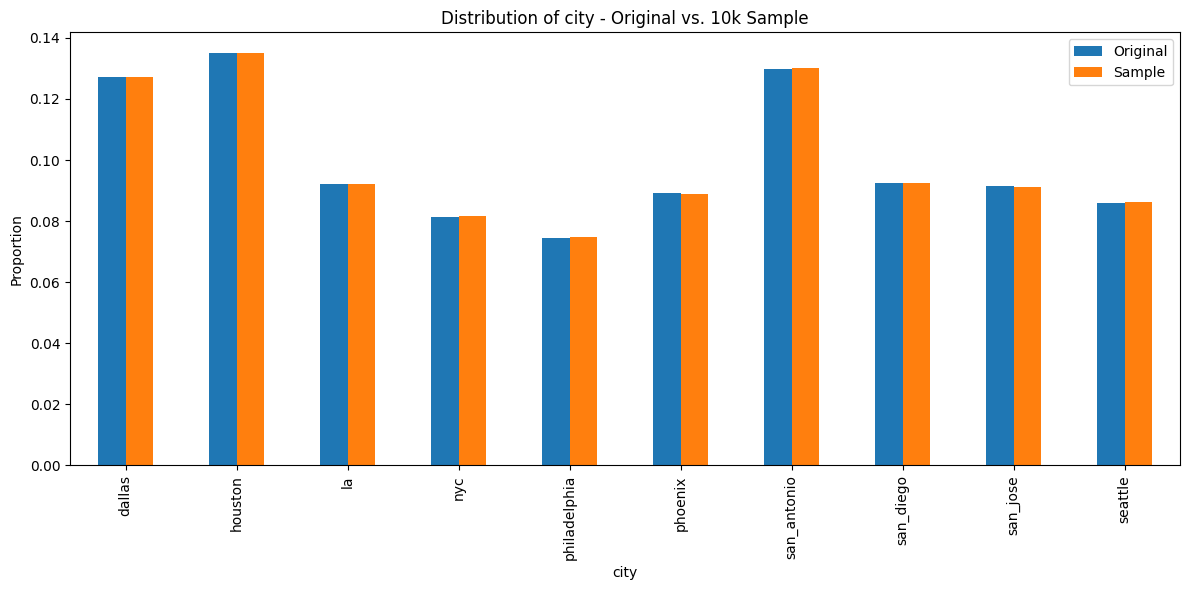


Hour distribution:


,Original,Sample
hour,,
0,0.050303,0.0504
1,0.041773,0.0420
2,0.041609,0.0417
3,0.041547,0.0415
4,0.041739,0.0416


<Figure size 1200x600 with 0 Axes>

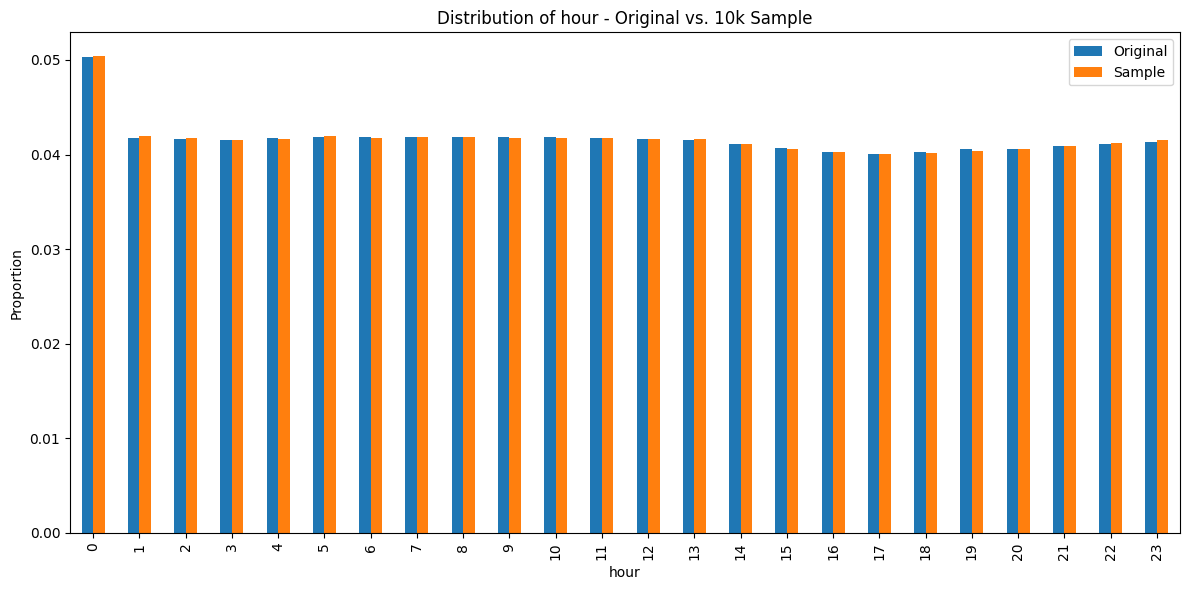


Dayofweek distribution:


,Original,Sample
dayofweek,,
0,0.145043,0.1480
1,0.144514,0.1444
2,0.142744,0.1408
3,0.142553,0.1361
4,0.140632,0.1382


<Figure size 1200x600 with 0 Axes>

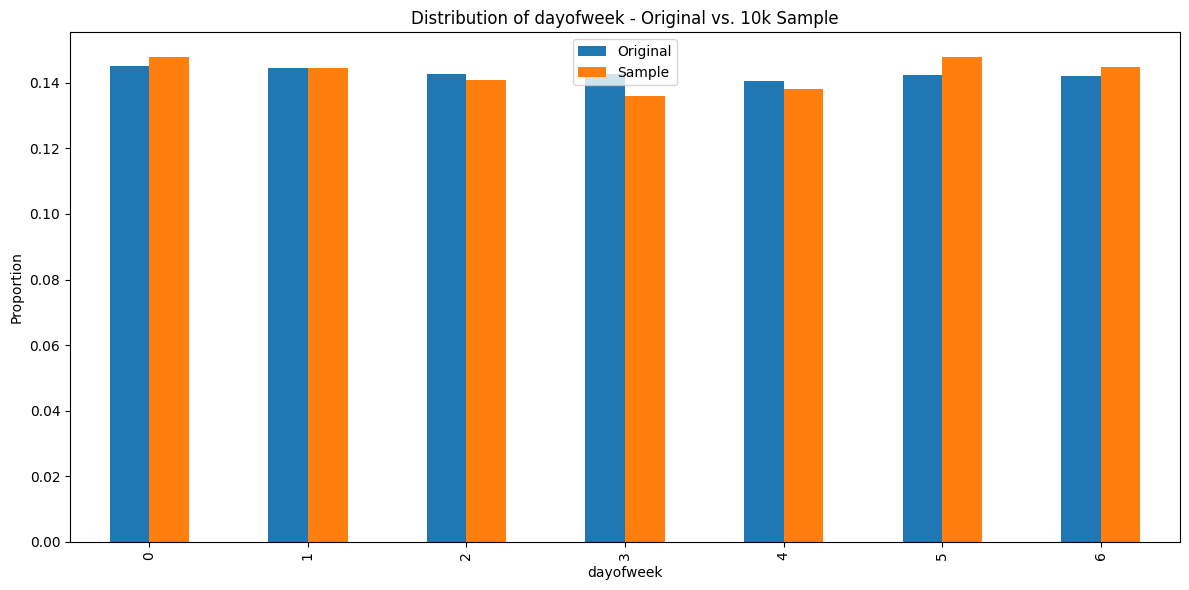


Season distribution:


,Original,Sample
season,,
autumn,0.269910,0.2720
spring,0.240482,0.2403
summer,0.231405,0.2313
winter,0.258202,0.2564


<Figure size 1200x600 with 0 Axes>

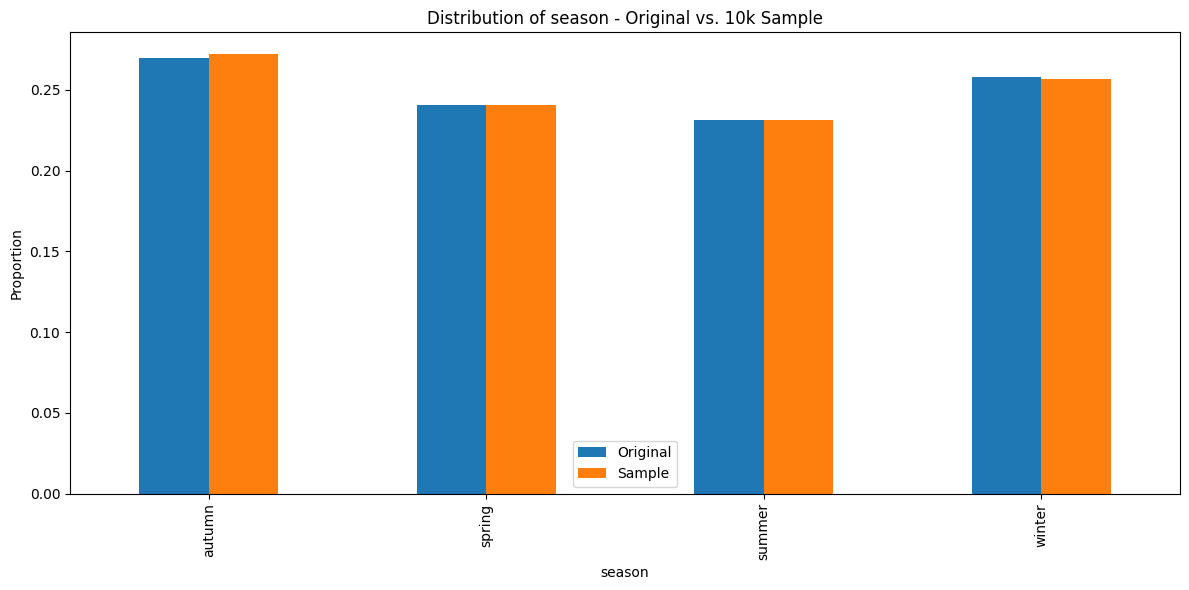

In [6]:
strata_columns = ['city', 'hour', 'dayofweek', 'season']

# Check if the columns exist in the data
missing_cols = [col for col in strata_columns if col not in data.columns]
if missing_cols:
    print(f"Warning: The following stratification columns are missing: {missing_cols}")
    # Use only available columns
    strata_columns = [col for col in strata_columns if col in data.columns]
    
if strata_columns:
    print(f"Creating stratified samples using columns: {strata_columns}")
    
    # Create samples of different sizes for different use cases
    sample_sizes = [5000, 10000, 20000]
    
    samples = {}
    for size in sample_sizes:
        sample_name = f"sample_{size}"
        samples[sample_name] = create_stratified_sample(data, strata_columns, sample_size=size)
        print(f"Created {sample_name} with shape: {samples[sample_name].shape}")
        
    # Compare distributions between original and sampled data
    print("\nDistribution comparison between original and 10k sample:")
    
    for col in strata_columns:
        print(f"\n{col.capitalize()} distribution:")
        original_dist = data[col].value_counts(normalize=True).sort_index()
        sample_dist = samples['sample_10000'][col].value_counts(normalize=True).sort_index()
        
        comparison = pd.DataFrame({
            'Original': original_dist,
            'Sample': sample_dist
        }).fillna(0)
        
        display(comparison.head())
        
        # Plot distribution comparison
        plt.figure(figsize=(12, 6))
        comparison.plot(kind='bar', figsize=(12, 6))
        plt.title(f'Distribution of {col} - Original vs. 10k Sample')
        plt.xlabel(col)
        plt.ylabel('Proportion')
        plt.tight_layout()
        plt.show()
else:
    print("No stratification columns available. Cannot create stratified samples.")

In [8]:
# Validate the sampling quality
print("\n=== Sampling Quality Validation ===")

# Select numerical columns for statistical comparison
numerical_columns = ['demand', 'temperature', 'humidity', 'windSpeed', 'pressure']
available_num_cols = [col for col in numerical_columns if col in data.columns]

if available_num_cols:
    # Create a dataframe to compare statistics between original and sampled datasets
    validation_results = []
    
    for col in available_num_cols:
        # Original dataset statistics
        orig_mean = data[col].mean()
        orig_median = data[col].median()
        orig_std = data[col].std()
        orig_min = data[col].min()
        orig_max = data[col].max()
        
        # Sample dataset statistics (using 10k sample)
        sample_mean = samples['sample_10000'][col].mean()
        sample_median = samples['sample_10000'][col].median()
        sample_std = samples['sample_10000'][col].std()
        sample_min = samples['sample_10000'][col].min()
        sample_max = samples['sample_10000'][col].max()
        
        # Calculate percentage differences
        mean_diff_pct = (sample_mean - orig_mean) / orig_mean * 100 if orig_mean != 0 else 0
        median_diff_pct = (sample_median - orig_median) / orig_median * 100 if orig_median != 0 else 0
        std_diff_pct = (sample_std - orig_std) / orig_std * 100 if orig_std != 0 else 0
        min_diff_pct = (sample_min - orig_min) / orig_min * 100 if orig_min != 0 else 0
        max_diff_pct = (sample_max - orig_max) / orig_max * 100 if orig_max != 0 else 0
        
        validation_results.append({
            'column': col,
            'mean': orig_mean,
            'median': orig_median,
            'std': orig_std,
            'min': orig_min,
            'max': orig_max,
            'sample_mean': sample_mean,
            'sample_median': sample_median,
            'sample_std': sample_std,
            'sample_min': sample_min,
            'sample_max': sample_max,
            'mean_diff_pct': mean_diff_pct,
            'median_diff_pct': median_diff_pct,
            'std_diff_pct': std_diff_pct,
            'min_diff_pct': min_diff_pct,
            'max_diff_pct': max_diff_pct
        })
    
    # Create and display the validation dataframe
    validation_df = pd.DataFrame(validation_results)
    display(validation_df)
    
    # Check for significant differences (e.g., more than 5% difference)
    threshold = 5.0  # 5% difference threshold
    problematic_stats = validation_df[
        (abs(validation_df['mean_diff_pct']) > threshold) |
        (abs(validation_df['median_diff_pct']) > threshold) |
        (abs(validation_df['std_diff_pct']) > threshold)
    ]
    
    if len(problematic_stats) > 0:
        print("\nWarning: The following columns have significant statistical differences (>5%) between original and sample:")
        display(problematic_stats[['column', 'mean_diff_pct', 'median_diff_pct', 'std_diff_pct']])
    else:
        print("\nAll numerical columns maintain good statistical consistency between original and sampled data.")
else:
    print("No numerical columns available for statistical validation.")


=== Sampling Quality Validation ===


,column,mean,median,std,min,max,sample_mean,sample_median,sample_std,sample_min,sample_max,mean_diff_pct,median_diff_pct,std_diff_pct,min_diff_pct,max_diff_pct
0,demand,7696.245930,7137.00,4764.377056,-1340.00,22449.00,7689.606311,7090.000,4787.422610,-99.00,22339.01,-0.086271,-0.658540,0.483706,-92.611940,-0.489955
1,temperature,64.458584,63.96,15.469080,17.87,110.24,64.441628,63.845,15.460750,19.39,110.05,-0.026305,-0.179800,-0.053852,8.505876,-0.172351
2,humidity,0.661283,0.70,0.216651,0.02,1.00,0.659730,0.700,0.218348,0.02,1.00,-0.234801,0.000000,0.783311,0.000000,0.000000
3,windSpeed,5.816573,5.16,3.213103,0.00,15.24,5.819154,5.180,3.223078,0.01,15.24,0.044365,0.387597,0.310444,0.000000,0.000000
4,pressure,1016.074078,1015.50,5.455819,1001.20,1030.80,1016.147270,1015.700,5.436602,1001.20,1030.80,0.007203,0.019695,-0.352236,0.000000,0.000000



All numerical columns maintain good statistical consistency between original and sampled data.


## Saving the Stratified Samples

In [9]:
# Save the sampled datasets to file
os.makedirs('./dataset/processed/samples', exist_ok=True)

for sample_name, sample_df in samples.items():
    output_path = f"./dataset/processed/samples/{sample_name}_clean_merged_data.csv"
    sample_df.to_csv(output_path, index=False)
    print(f"Saved {sample_name} to {output_path}")

print("\nTo use these samples in your clustering analysis, load them instead of the full dataset:")
print("data_path = './dataset/processed/samples/sample_10000_clean_merged_data.csv'")

Saved sample_5000 to ./dataset/processed/samples/sample_5000_clean_merged_data.csv
Saved sample_10000 to ./dataset/processed/samples/sample_10000_clean_merged_data.csv
Saved sample_20000 to ./dataset/processed/samples/sample_20000_clean_merged_data.csv

To use these samples in your clustering analysis, load them instead of the full dataset:
data_path = './dataset/processed/samples/sample_10000_clean_merged_data.csv'
